In [1]:
#network.py

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

class HopfieldNetwork(object):
    def train_weights(self, train_data):
        print("Start to train weights...")
        num_data = len(train_data)
        self.num_neuron = train_data[0].shape[0]
        
        #initialise weights
        W = np.zeros((self.num_neuron, self.num_neuron))
        rho = np.sum([np.sum(t) for t in train_data]) / (num_data * self.num_neuron)
        
        #Hebb rule
        for i in tqdm(range(num_data)):
            t = train_data[i] - rho
            W += np.outer(t, t)
            
        #Make diagonal element of W into 0
        diagW = np.diag(np.diag(W))
        W = W - diagW
        W /= num_data
        
        self.W = W
        
    def predict(self, data, num_iter = 20, threshold = 0, asyn = False):
        print("Start to predict...")
        self.num_iter = num_iter
        self.threshold = threshold
        self.asyn = asyn
        
        #Copy to avoid call by reference
        copied_data = np.copy(data)
        
        #Define predict list
        predicted = []
        for i in tqdm(range(len(data))):
            predicted.append(self._run(copied_data[i]))
        return predicted
    
    def _run(self, init_s):
        if self.asyn == False:
            """
            Synchronous update
            """
            #Compute initial state energy
            s = init_s
            
            e = self.energy(s)
            
            #Iteration
            for i in range(self.num_iter):
                #Update s
                s = np.sign(self.W @ s - self.threshold)
                #Compute new state energy
                e_new = self.energy(s)
                
                #s is converged
                if e == e_new:
                    return s
                #update energy
                e = e_new
                
            return s
        else:
            """
            Asynchronous update
            """
            #Compute initial state energy
            s = init_s
            e = self.energy(s)
            
            #Iteration
            for i in range(self.num_iter):
                for j in range(100):
                    #Select random neuron
                    idx = np.random.randint(0, self.num_neuron)
                    #Update s
                    s[idx] = np.sign(self.W[idx].T@s - self.threshold)
                    
                #Compute new state energy
                e_new = self.energy(s)
                
                #if s is converged
                if e == e_new:
                    return s
                #Update energy
                e = e_new
                
            return s
        
    def energy(self, s):
        return -0.5 * s @ self.W @ s + np.sum(s * self.threshold)
    
    def plot_weights(self):
        plt.figure(figsize=(6, 5))
        w_mat = plt.imshow(self.W, cmap = cm.coolwarm)
        plt.colorbar(w_mat)
        plt.title("Network Weights")
        plt.tight_layout()
        plt.savefig("weights.png")
        plt.show()

Start to data preprocessing...
Start to train weights...


100%|██████████| 4/4 [00:03<00:00,  1.21it/s]


Start to predict...


100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


Show prediction results...


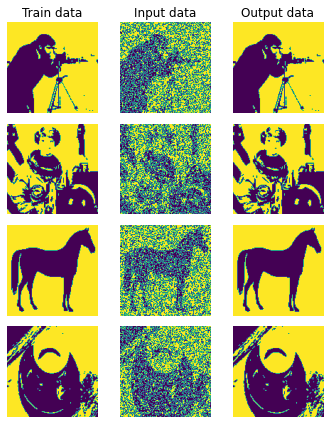

Show network weights matrix...


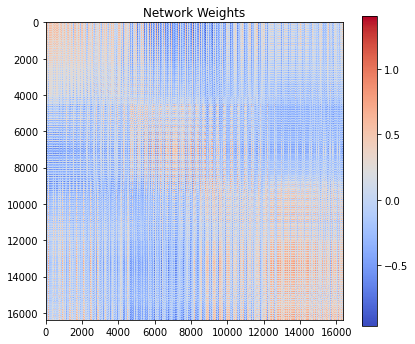

In [2]:
#train.py

import numpy as np
np.random.seed(1)
import matplotlib.pyplot as plt
import skimage.data
from skimage.color import rgb2gray
from skimage.filters import threshold_mean
from skimage.transform import resize
import network

#Utils
def get_corrupted_input(input, corruption_level):
    corrupted = np.copy(input)
    inv = np.random.binomial(n=1, p=corruption_level, size=len(input))
    for i, v in enumerate(input):
        if inv[i]:
            corrupted[i] = -1 * v
    return corrupted

def reshape(data):
    dim = int(np.sqrt(len(data)))
    data = np.reshape(data, (dim, dim))
    return data

def plot(data, test, predicted, figsize=(5, 6)):
    data = [reshape(d) for d in data]
    test = [reshape(d) for d in test]
    predicted = [reshape(d) for d in predicted]
    
    fig, axarr = plt.subplots(len(data), 3, figsize = figsize)
    for i in range(len(data)):
        if i == 0:
            axarr[i, 0].set_title("Train data")
            axarr[i, 1].set_title("Input data")
            axarr[i, 2].set_title("Output data")
            
        axarr[i, 0].imshow(data[i])
        axarr[i, 0].axis("off")
        axarr[i, 1].imshow(test[i])
        axarr[i, 1].axis("off")
        axarr[i, 2].imshow(predicted[i])
        axarr[i, 2].axis("off")
        
    plt.tight_layout()
    plt.savefig("result.png")
    plt.show()
    
def preprocessing(img, w=128, h=128):
    #Resize image
    img = resize(img, (w, h), mode="reflect")
    
    #Thresholding
    thresh = threshold_mean(img)
    binary = img > thresh
    shift = 2*(binary*1) - 1 #boolean to int
    
    #Reshape
    flatten = np.reshape(shift, (w*h))
    return flatten

def main():
    #Load data
    camera = skimage.data.camera()
    astronaut = rgb2gray(skimage.data.astronaut())
    horse = skimage.data.horse()
    coffee = rgb2gray(skimage.data.coffee())
    
    #Merge data
    data = [camera, astronaut, horse, coffee]
    
    #Preprocessing
    print("Start to data preprocessing...")
    data = [preprocessing(d) for d in data]
    
    #Create Hopfield network model
    model = network.HopfieldNetwork()
    model.train_weights(data)
    
    #Generate test_set
    test = [get_corrupted_input(d, 0.3) for d in data]
    
    predicted = model.predict(test, threshold=0, asyn=False)
    print("Show prediction results...")
    plot(data, test, predicted)
    print("Show network weights matrix...")
    model.plot_weights()
    
if __name__ == "__main__":
    main()

Start to data preprocessing...
Start to train weights...


100%|██████████| 3/3 [00:00<00:00, 428.46it/s]


Start to predict...


100%|██████████| 3/3 [00:00<00:00, 71.41it/s]

Show prediction results...


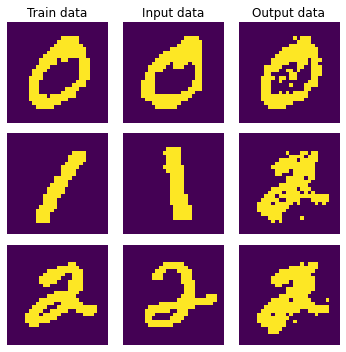

Show network weights matrix...


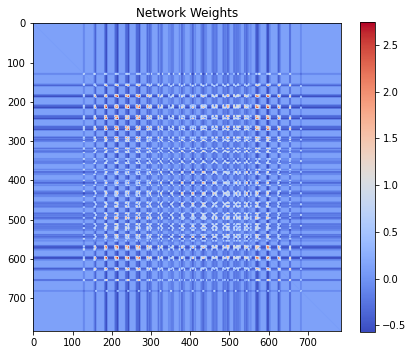

In [3]:
#train_mnist.py

import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_mean
import network
from keras.datasets import mnist

#Utils
def reshape(data):
    dim = int(np.sqrt(len(data)))
    data = np.reshape(data, (dim, dim))
    return data

def plot(data, test, predicted, figsize = (3, 3)):
    data = [reshape(d) for d in data]
    test = [reshape(d) for d in test]
    predicted = [reshape(d) for d in predicted]
    
    fig, axarr = plt.subplots(len(data), 3, figsize = figsize)
    for i in range(len(data)):
        if i == 0:
            axarr[i, 0].set_title("Train data")
            axarr[i, 1].set_title("Input data")
            axarr[i, 2].set_title("Output data")
            
        axarr[i, 0].imshow(data[i])
        axarr[i, 0].axis("off")
        axarr[i, 1].imshow(test[i])
        axarr[i, 1].axis("off")
        axarr[i, 2].imshow(predicted[i])
        axarr[i, 2].axis("off")
        
    plt.tight_layout()
    plt.savefig("result_mnist.png")
    plt.show()
    
def preprocessing(img):
    w, h = img.shape
    #Thresholding
    thresh = threshold_mean(img)
    binary = img > thresh
    shift = 2*(binary*1) - 1 #Boolean to int
    
    #Reshape
    flatten = np.reshape(shift, (w*h))
    return flatten

def main():
    #load data
    (x_train, y_train), (_, _) = mnist.load_data()
    data = []
    for i in range(3):
        xi = x_train[y_train==i]
        data.append(xi[0])
        
    #Preprocessing
    print("Start to data preprocessing...")
    data = [preprocessing(d) for d in data]
    
    #create Hopfield network model
    model = network.HopfieldNetwork()
    model.train_weights(data)
    
    #make test datalist
    test = []
    for i in range(3):
        xi = x_train[y_train==i]
        test.append(xi[1])
        
    test = [preprocessing(d) for d in test]
    
    predicted = model.predict(test, threshold=50, asyn = True)
    print("Show prediction results...")
    plot(data, test, predicted, figsize=(5, 5))
    print("Show network weights matrix...")
    model.plot_weights()
    
if __name__ == "__main__":
    main()